Research studies performance of different architectures with similar number of trainable parameters

In [1]:
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil

import datetime
import pprint

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from seismicpro.batchflow import Pipeline, C, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7, VGG16, VGG19, ResNet, VGG
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.batchflow.batchflow.research import Research, Option, KV, Results
from seismicpro.batchflow.batchflow.utils import plot_results_by_config

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss, attention_loss, UnetAtt
from seismicpro.models.unetatt_3 import UnetAttention4, UnetAttention3


from Ground_Roll.src.unet_att2_params import UnetAttParams
from Ground_Roll.src.metric_utils import validate_all
from Ground_Roll.src.utils import make_index, check_res

%env CUDA_VISIBLE_DEVICES=3
GPUs=[3]

env: CUDA_VISIBLE_DEVICES=3


## Load Dataset

In [2]:
paths = dict(raw = 'data/FR_train_1_raw.sgy', lift = 'data/FR_train_1_lift.sgy')
index_tr = make_index(paths, extra_headers=['offset'])
print("Number of fields in train set:", len(index_tr))

tindex_tr = TraceIndex(index_tr)
train_set = SeismicDataset(tindex_tr)
print("Number of traces in train set:", len(tindex_tr))

Number of fields in train set: 90
Number of traces in train set: 129600


In [3]:
paths = dict(raw = 'data/FR_train_2_raw.sgy', lift = 'data/FR_train_2_lift.sgy')
index_te = make_index(paths, extra_headers=['offset'])
index_te = index_te.create_subset(index_te.indices[:20])
print("Number of fields in test set:", len(index_te))
print("Fields in test: ", index_te.indices)

tindex_te = TraceIndex(index_te)
test_set = SeismicDataset(tindex_te)
print("Number of traces in test set:", len(tindex_te))

Number of fields in test set: 20
Fields in test:  Int64Index([109207, 109208, 109210, 109211, 109213, 109214, 109216, 109217,
            109219, 109220, 109222, 109223, 109225, 109226, 109228, 109229,
            109290, 109291, 109293, 109294],
           dtype='int64', name='FieldRecord')
Number of traces in test set: 28800


## Define grid
### Define configs for models

In [4]:
common_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   lift={'name': 'targets', 'shape': (3000, 1)}),
    'optimizer': ('Adam', {'learning_rate': 0.0001}),
    'common/data_format': 'channels_last',
}

main_bl_config = {
    'encoder/num_stages': 4,
    'encoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128], kernel_size=7, activation=tf.nn.elu),
    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'encoder/order': ['block', 'skip', 'downsampling'],
    'embedding': dict(layout='caca', kernel_size=7, filters=256),
    'decoder/num_stages': 4,
    'decoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128][::-1],
                           kernel_size=7, activation=tf.nn.elu),
    'decoder/upsample': dict(layout='tad', kernel_size=7, strides=2,
                             filters=[16, 32, 64, 128][::-1],
                             dropout_rate=0.05, activation=tf.nn.elu,),
    'decoder/order': ['upsampling', 'combine', 'block'],
}

unetatt_old_bl_config = {
    'loss': (attention_loss, {'balance': 0.05}),
    'body': {'main': main_bl_config,
    'attn': {
                'encoder/num_stages': 3,
                'encoder/blocks': dict(layout='caca', filters=[8, 16, 32], kernel_size=3, activation=tf.nn.elu),
                'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
                'embedding': dict(layout='caca', filters=64, kernel_size=3, activation=tf.nn.elu),
                'decoder/num_stages': 3,
                'decoder/blocks': dict(layout='caca', filters=[8, 16, 32][::-1], kernel_size=3, activation=tf.nn.elu),
                'decoder/upsample': dict(layout='tad', filters=[8, 16, 32][::-1], kernel_size=3, strides=2,
                                 dropout_rate=0.05, activation=tf.nn.elu),
            },
    },
    'train_steps': {
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': ['attention_branch', 'attention_dense']},
    }
}

main_config_small = {
    'encoder/num_stages': 4,
    'encoder/blocks': dict(layout='caca', 
                           filters=[16, 32, 64, 128], 
                           kernel_size=[7, 5, 5, 5], 
                           activation=tf.nn.elu),
    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'encoder/order': ['block', 'skip', 'downsampling'],
    'embedding': dict(layout='ca ca', kernel_size=5, filters=256),
    'decoder/num_stages': 4,
    'decoder/blocks': dict(layout='caca', 
                           filters=[16, 32, 64, 128][::-1],
                           kernel_size=[7, 5, 5, 5][::-1], 
                           activation=tf.nn.elu),
    'decoder/upsample': dict(layout='tad',
                             filters=[16, 32, 64, 128][::-1],
                             kernel_size=[7, 5, 5, 5][::-1], 
                             strides=2, dropout_rate=0.05, activation=tf.nn.elu,),
    'decoder/order': ['upsampling', 'combine', 'block'],
}

unetatt_new_small_config = {
    'loss': (attention_loss, {'balance': 0.05}),
    'body' : main_config_small,
    'body/attention': {'blocks': dict(layout='caca', filters=[128, 64, 32, 16], kernel_size=5, activation=tf.nn.elu),
                       'upsample': dict(layout='tad', filters=[128, 64, 32, 16], kernel_size=5, strides=2,
                                        dropout_rate=0.05, activation=tf.nn.elu)},
}

unetatt2_new_small_config = {
    **unetatt_new_small_config,
    'body/attention/skip': True
}

unetatt_new_small_for4_config = {
    **unetatt_new_small_config,
    'body/attention': {'blocks': dict(layout='caca', filters=[128, 64, 32, 16], kernel_size=[3, 5, 5, 5], activation=tf.nn.elu),
                       'upsample': dict(layout='tad', filters=[128, 64, 32, 16], kernel_size=[3, 5, 5, 5], strides=2,
                                        dropout_rate=0.05, activation=tf.nn.elu)},
}

m1_vgg_small = {
    'loss': (attention_loss_gauss, {'balance': 0.05}),
    'common/main_base_class': UNet,
    'common/att_base_class': VGG,
    'body': {
        'main': main_config_small,
        'att': {'arch': [
                                (3, 0, 16, 1),
                                (3, 0, 32, 1),
                                (3, 0, 64, 1),
                                (3, 0, 128, 1),
                                (2, 0, 256, 1),
                            ]
            },
    },
    'head': {
        'main': dict(layout='c', filters=1, units=1),
        'att': dict(layout='fa', units=2, activation=h_sigmoid),
    },
    
    'train_steps': {'step_main': {'scope': 'main_branch'},
                 'step_attention': {'scope': 'attention_branch'}}
}

m1_resnet_small = {
    **m1_vgg_small,
    'common/att_base_class': ResNet,
    'body/att': {'num_blocks': [2, 2, 2, 2], 'filters': [16, 32, 64, 128], 'kernel_size': 5},
}

m3_vgg = {
    **m1_vgg_small,
    'head/mode': 'noise'
}

m3_resnet = {
    **m1_resnet_small,
    'head/mode': 'noise'
}

### Match models and configs

In [5]:
items = (
    ('egor_baseline', UnetAtt, {**common_config, **unetatt_old_bl_config}, 'loss_step_main'),
    ('unetatt2_small', UnetAttention3, {**common_config, **unetatt2_new_small_config}, 'loss'),
    ('unetatt3_small', UnetAttention3, {**common_config, **unetatt_new_small_config}, 'loss'),
    ('unetatt4_small', UnetAttention4, {**common_config, **unetatt_new_small_for4_config}, 'loss'),
    ('m1_vgg_small', UnetAttParams, {**common_config, **m1_vgg_small}, 'loss_step_main'),  
    ('m1_resnet_small', UnetAttParams, {**common_config, **m1_resnet_small}, 'loss_step_main'),
    ('m3_vgg_small', UnetAttParams, {**common_config, **m3_vgg}, 'loss_step_main'),  
    ('m3_resnet_small', UnetAttParams, {**common_config, **m3_resnet}, 'loss_step_main'),
)

keys, models, configs, losses = tuple(zip(*items))

grid = Option.product(Option('model', models), 
                      Option('model_config', [KV(c, alias=k) for k, c in zip(keys, configs)]),
                      Option('loss_name', losses))
print(list(grid.gen_configs()))

[ConfigAlias({'loss_name': 'loss_step_main', 'model': 'UnetAtt', 'model_config': 'egor_baseline'}), ConfigAlias({'loss_name': 'loss', 'model': 'UnetAttention3', 'model_config': 'unetatt2_small'}), ConfigAlias({'loss_name': 'loss', 'model': 'UnetAttention3', 'model_config': 'unetatt3_small'}), ConfigAlias({'loss_name': 'loss', 'model': 'UnetAttention4', 'model_config': 'unetatt4_small'}), ConfigAlias({'loss_name': 'loss_step_main', 'model': 'UnetAttParams', 'model_config': 'm1_vgg_small'}), ConfigAlias({'loss_name': 'loss_step_main', 'model': 'UnetAttParams', 'model_config': 'm1_resnet_small'}), ConfigAlias({'loss_name': 'loss_step_main', 'model': 'UnetAttParams', 'model_config': 'm3_vgg_small'}), ConfigAlias({'loss_name': 'loss_step_main', 'model': 'UnetAttParams', 'model_config': 'm3_resnet_small'})]


For reference: number of trainable parameters in models:


| model | trainable params|
|-------|-----------------|
|egor_baseline| 1 721 117|
|unetatt2_small| 1 747 794|
|unetatt3_small| 1 747 794|
|unetatt4_small| 1 693 266|
|m1_vgg_small| 1 711 395|
|m1_resnet_small| 1 691 955|
|m3_vgg_small| 1 711 395|
|m3_resnet_small| 1 691 955|

## Research pipeline

In [6]:
BATCH_SIZE=64
ITERATIONS=6075 # ~ 3 epochs of train 
TEST_EXECUTE_FREQ=1000

In [7]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw), 'lift': exp_stack(batch.lift)}

def make_data_inference(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw)}


train_template = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_model('dynamic', C('model'), name='unet', config=C('model_config'))
                  .init_variable('train_loss')
                  .train_model('unet', make_data=make_data, fetches=C('loss_name'),
                               save_to=V('train_loss'))
                  .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)
                 )

test_template = (Pipeline()
                 .init_variable('test_loss')
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .import_model('unet', C('import_from'))
                 .predict_model('unet', make_data=make_data, fetches=C('loss_name'),
                                save_to=V('test_loss'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))


## Function to dump models outputs in the end of training

In [8]:
def dump_results(iteration, experiment, train_ppl, val_set):
    
    tmp_dump_path = os.path.join(experiment[train_ppl].path, 'tmp')
    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path)
    os.makedirs(tmp_dump_path)
    
    inference_pipeline = (val_set.p
                         .load(components='raw', fmt='segy', tslice=np.arange(3000))
                         .import_model('unet', experiment[train_ppl].pipeline)
                         .predict_model('unet', make_data=make_data_inference, fetches=["out_lift"], save_to=B('raw'))
                         .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()), src='raw', fmt='segy', split=False)
                         )

    inference_pipeline.run(1000, n_epochs=1, drop_last=False, shuffle=False, bar=False)
    
    output_path = os.path.join(experiment[train_ppl].path, 'res.sgy')
    merge_segy_files(output_path=output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy'), bar=False)

    if os.path.exists(tmp_dump_path):
        shutil.rmtree(tmp_dump_path) 
    
    return output_path


### Run research (~30 hours)

In [9]:
!rm -r 9_research_res

In [10]:
res_name = '9_research_res'

train_template = train_template << train_set
test_template = test_template << test_set

research = (Research()
            .add_pipeline(train_template, #dataset=train_set, part='train',
                          variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, #dataset=train_set, part='test', 
                          variables='test_loss', name='test_ppl',
                          execute=[TEST_EXECUTE_FREQ, 'last'], run=True, 
                          import_from='train_ppl')
            .add_function(dump_results, returns='output_path', name='dump_res_fn',
                          execute='last', train_ppl='train_ppl', val_set=test_set)
            .add_grid(grid)
            )

research.run(n_iters=ITERATIONS, n_reps=3, timeout=15, name=res_name, bar=True, gpu=GPUs)


Research 9_research_res is starting...


  0%|          | 0/145800 [00:00<?, ?it/s]

Distributor has 24 jobs with 6075 iterations. Totally: 145800


100%|██████████| 145800/145800 [19:46:55<00:00,  2.05it/s]  


## Analysing Results

In [11]:
res = research.load_results(use_alias=True)

In [12]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145992 entries, 0 to 0
Data columns (total 7 columns):
config         145992 non-null object
iteration      145992 non-null int64
name           145992 non-null object
output_path    24 non-null object
repetition     145992 non-null int64
test_loss      168 non-null float64
train_loss     145800 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 8.9+ MB


### Draw plots with losses

In [13]:
# batchflow not updated to latest yet
def plot_results_by_config(results, variables, figsize=None, force_flat=True):
    if isinstance(variables, dict):
        variables = variables.items()
    elif len(variables) == 2 and isinstance(variables[0], str):
        variables = (variables,)

    gbc = results.groupby('config')
    n_configs = len(gbc)
    n_vars = len(variables)

    n_h, n_v = (n_configs, 1) if n_vars == 1 and force_flat else (n_vars, n_configs)

    if figsize is None:
        figsize = (n_h * 5, n_v * 5)

    _, axs = plt.subplots(n_v, n_h, figsize=figsize)
    for x, (config, df) in enumerate(gbc):
        for y, (source, val) in enumerate(variables):
            if n_configs == 1 and n_vars == 1:
                ax = axs
            elif n_configs == 1:
                ax = axs[y]
            elif n_vars == 1:
                ax = axs[x]
            else:
                ax = axs[x, y]
            
            col = 'cv_split' if 'cv_split' in df.columns else 'repetition'

            (df[df['name'] == source]
             .pivot(index='iteration', columns=col, values=val)
             .rename(columns=lambda s: col + str(s))
             .plot(ax=ax))
            ax.set_title(config)
            ax.set_xlabel('Iteration')
            ax.set_ylabel(val.replace('_', ' ').capitalize())
            ax.grid(True)
            ax.legend()

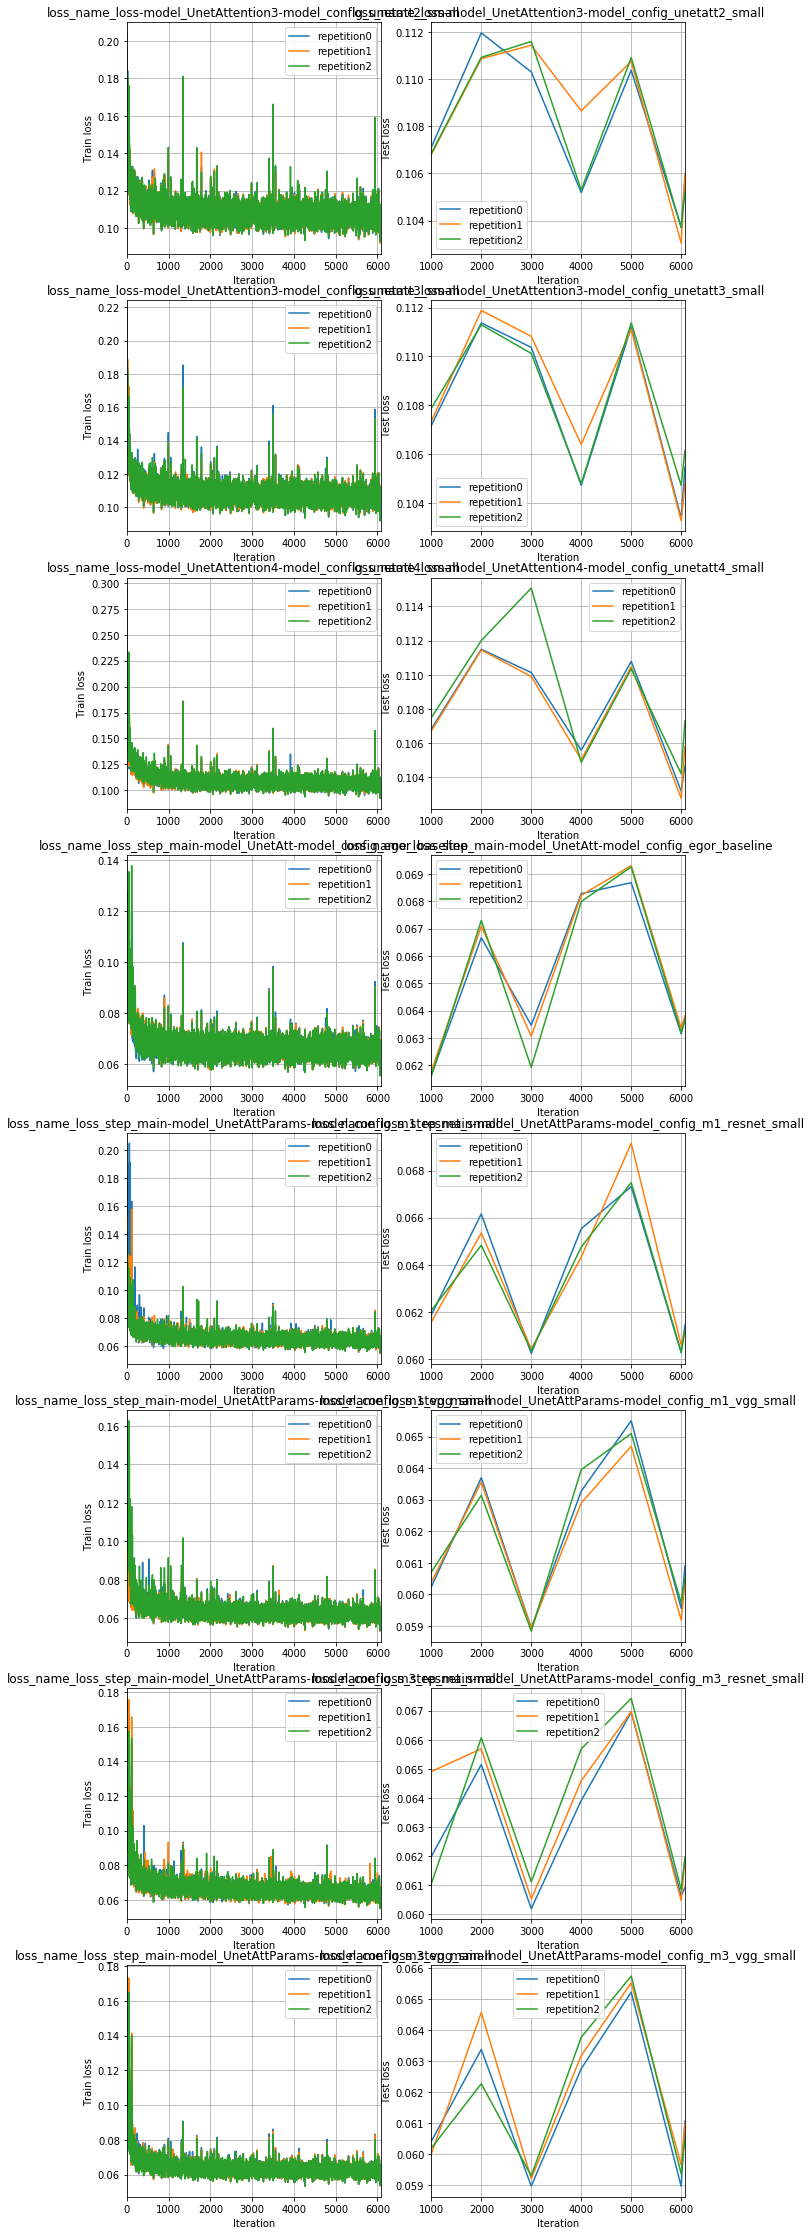

In [14]:
plot_results_by_config(res, {'train_ppl': 'train_loss', 'test_ppl': 'test_loss'})

### Load results to group by config

In [15]:
res2 = research.load_results()
res2.head()

,iteration,loss_name,model,model_config,name,output_path,repetition,test_loss,train_loss
0,0,loss_step_main,UnetAtt,egor_baseline,train_ppl,NaN,0,NaN,0.116679
1,1,loss_step_main,UnetAtt,egor_baseline,train_ppl,NaN,0,NaN,0.125572
2,2,loss_step_main,UnetAtt,egor_baseline,train_ppl,NaN,0,NaN,0.128089
3,3,loss_step_main,UnetAtt,egor_baseline,train_ppl,NaN,0,NaN,0.123049
4,4,loss_step_main,UnetAtt,egor_baseline,train_ppl,NaN,0,NaN,0.111216


### Calculate metric mu for model outputs from the end of each cv_split training

In [18]:
paths = res2[['model_config', 'repetition', 'output_path']].dropna()

results = {}
for mc, mcdf in paths.groupby('model_config'):
    print(mc)
    
    models_paths_dict = {'rep_' + str(i): os.path.abspath(p) for i, p in mcdf.set_index('repetition')['output_path'].items()}
    models_paths_dict.update(lift = 'data/FR_train_2_lift.sgy')
    comp = list(sorted(models_paths_dict.keys()))
    idx = make_index(models_paths_dict, extra_headers=['offset'])
    results[mc] = validate_all(idx, comp)
    

egor_baseline


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


m1_resnet_small


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


m1_vgg_small


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


m3_resnet_small


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


m3_vgg_small


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


unetatt2_small


100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


unetatt3_small


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


unetatt4_small


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


In [25]:
import pandas as pd
df_results_all = pd.concat(results,axis=1)
mu_avg = df_results_all.mean().groupby(level=0).mean().rename('mu_avg')

dat = {alias: model(config).get_number_of_trainable_vars() for alias, model, config, _ in items}

In [33]:
results = pd.DataFrame(data=dat, index=['trainable_params'])
results = results.append(res2[res2.iteration >= 4000].groupby('model_config')['train_loss'].mean().rename('train_loss it > 4000').transpose())
results = results.append(res2.groupby('model_config')['test_loss'].mean().transpose())
results = results.append(mu_avg.transpose())

(results.style
 .background_gradient(axis=None, cmap='Purples', subset=pd.IndexSlice['trainable_params', :])
 .background_gradient(axis=None, cmap='Blues', subset=pd.IndexSlice[['train_loss it > 4000','test_loss'], :])
 .background_gradient(axis=None, cmap='Blues', subset=pd.IndexSlice['mu_avg', :]))

,egor_baseline,m1_resnet_small,m1_vgg_small,m3_resnet_small,m3_vgg_small,unetatt2_small,unetatt3_small,unetatt4_small
trainable_params,1.72112e+06,1.69196e+06,1.7114e+06,1.69196e+06,1.7114e+06,1.74779e+06,1.74779e+06,1.69327e+06
train_loss it > 4000,0.0656584,0.064272,0.0621763,0.0642426,0.0622235,0.106548,0.106498,0.106446
test_loss,0.0650999,0.0631633,0.0616246,0.0632842,0.0616743,0.107926,0.107887,0.107909
mu_avg,1.29897,1.15703,1.20629,1.28817,1.1992,1.09855,1.10039,1.07522


In [68]:
results = pd.concat([res2[res2.iteration >= 4000].groupby(['model_config', 'repetition'])['train_loss'].mean().rename('train_loss it > 4000'),
                     res2.groupby(['model_config', 'repetition'])['test_loss'].mean()], axis=1)

results['avg_mu'] = df_results_all.mean().values

(results.style
 .background_gradient(axis=None, cmap='Blues', subset=['train_loss it > 4000','test_loss'])
 .background_gradient(axis=None, cmap='Blues', subset='avg_mu'))

### Results

Models of types m1, m3 (regression in attention branch) have smaller train and test losses but larger mu values on both set used for cross-validation and on validation set. they are smaller than baseline model. Models that share common encoder for main and attention (unetatt2-4) are bit larger and have better mu metric